## Imports 'n' stuff

In [1]:
# Just stuffed all the imports into one file
# The metadynamics class is in there

from all_imports import *

Imported all


In [2]:
# Available platforms
# Cuda no longer appears for me, but OpenCL is just as quick

platforms = [ mm.Platform.getPlatform(index).getName() for index in range(mm.Platform.getNumPlatforms()) ]
print (platforms) 

['Reference', 'CPU', 'OpenCL']


## Function Definition

In [3]:
def RunADP(Repeats, 
           NSteps, 
           nrpoints=500, 
           MyPlatform='OpenCL', 
           Verbose=True, 
           Verbose_plot=True,
          PickRandomTorsions=False,
          Bias_Width=0.5,
          Bias_Str=1.0,
          nrneigh=64):
    
    ######
    #
    # Repeats:            Number of times to run the metadynamics/Dmap loop
    # NSteps:             Number of steps to take in each metadynamics run
    # nrpoints:           Number of points to use in the DMap
    # MyPlatform:         Platform to use
    # Verbose:            Print stuff to screen
    # Verbose_plot:       Make plots
    # PickRandomTorsions: If True, will select random torsions rather than the best ones
    # Bias_Width:         The width of the biasing Gaussians in the metadynamics
    # Bias_Str:           The height of the biasing Gaussians
    # nrneigh:            Number of neighbour points for the DMap to consider
    #
    #######
    
    
    
    
    
    
    #############
    # Run Initial adp simulation 
    #############
    
    all_traj = [] 
    phi_torsion_all = []
    psi_torsion_all = []
    
    print(' Running initial sampling ')
    
    pdb_name='alanine_explicit.pdb'
    pdb = PDBFile(pdb_name) 
    forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, constraints=HBonds)
    
    integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.001*picoseconds)
    simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName(MyPlatform))
    simulation.context.setPositions(pdb.positions)

    iterations = NSteps//50
    phi = [1, 6, 8 ,14] #dihedral coordinates
    psi = [6, 8, 14, 16]

    potential_list = []
    torsion_list = []
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    st = time.time()
    lt=st
    for i in range(iterations):
        simulation.step(50)

        state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = True)
        positions = simulation.context.getState(getPositions=True).getPositions()
        coordinates = positions.value_in_unit(nanometer)
        dihedral = np.zeros(2)

        dihedral[0] = compute_torsion(coordinates, phi[0],phi[1],phi[2],phi[3]).value_in_unit(degree)
        dihedral[1] = compute_torsion(coordinates, psi[0],psi[1],psi[2],psi[3]).value_in_unit(degree)
        torsion_list.append(dihedral)
        potential_list.append(state.getPotentialEnergy().value_in_unit(kilojoule/mole))

        if (time.time()-lt)>10 and Verbose:
            print(str(i*50)+' of '+str(iterations*50))
            lt = time.time()
    if (Verbose):
        print('Done Initial. Time='+str(np.round(time.time()-st,2)))

    if (Verbose_plot):
    #Converting generated lists to numpy arrays
        torsion_list = np.array(torsion_list)
        potential_list = np.array(potential_list)

        plt.scatter(torsion_list[:,0],torsion_list[:,1],edgecolor='k',alpha=.25)
        plt.xlabel(r'$\phi$')
        plt.ylabel(r'$\psi$')
        plt.xlim([-180,180])
        plt.ylim([-180,180])
        plt.grid(1)
        plt.show()
        
        
    ################
    # Begin main algorithm loop.
    ################
    
    ncv1 = [] 
    
    for Meta_i in range(Repeats):
        print(' ')
        print('Running repeat run '+str(Meta_i+1)+' of '+str(Repeats))
        print(' ')
        print(' -- MDFeature')
        
        ############
        # Run DMap on trajectory first
        ############
        
        saving_file = 'trajectory.dcd' 
        forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
        system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, constraints=HBonds) 
        integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
        #Change reference to a suitable platform here:
        simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName(MyPlatform))
        simulation.context.setPositions(pdb.positions)
        simulation.context.setVelocitiesToTemperature(300*kelvin)

        # check the loaded topology
 
        topology = md.load(pdb_name).topology 

        table, bonds = topology.to_dataframe()
        #print(table)

        mdinit = md.load_pdb(pdb_name)
        traj_std_tmp = md.load_dcd('trajectory.dcd', mdinit.topology)
        burn = len(traj_std_tmp)//10
        traj_orig = traj_std_tmp[burn:]
        print('loaded traj: ', traj_orig )
        if len(all_traj)<1:
            all_traj = traj_orig
        else:
            all_traj = all_traj + traj_orig
        print('all traj: ', all_traj)
            
        all_traj = all_traj.superpose(all_traj[0])
        #nrpoints = np.min([ len(all_traj) , NRPOINTS ] )
        st = time.time() 
        mydmap, traj = diffusionmap.compute_diffusionmaps(all_traj.remove_solvent(), 
                                                          nrpoints=nrpoints, 
                                                          nrneigh=nrneigh,
                                                          epsilon=1.0)
        print('Time taken for DMap: ', time.time()-st)
        phi = [1, 6, 8 ,14] #dihedral coordinates
        psi = [6, 8, 14, 16]
        zeta = [1, 4, 6, 8]
        theta = [8, 14, 16, 18]
    
        atom_indices = topology.select_atom_indices('heavy') 
        all_combinations = features.create_torsions_list(atoms=atom_indices, print_list=False) 
    
        
        #list_of_functions =['compute_cos_torsion_mdraj' for _ in range(len(all_combinations))]
        list_of_functions =['scan' for _ in range(len(all_combinations))]
        correlations = features.compute_all_correlations(traj, 
                                                         mydmap, 
                                                         2, 
                                                         list_of_functions, 
                                                         nevery=1, 
                                                         list_of_params=all_combinations,
                                                        progress_bar=False)
        # choose the two best ones?
        if (PickRandomTorsions):
            print('Picking two random torsions!')
            cv_indices = np.vstack( [all_combinations[ np.random.choice(np.arange(len(all_combinations)),1) ],
          all_combinations[ np.random.choice(np.arange(len(all_combinations)),1) ] ])
        else:
            cv_indices, correlations_cv, cv_indices_2, correlations_cv_2 = features.identify_features(correlations, 
                                                                                                      all_combinations, 
                                                                                                      2)
         
        ncv1 = [int(cv_indices[0][0] ),int(cv_indices[0][1] ),int(cv_indices[0][2] ),int(cv_indices[0][3] )]
        ncv2 = [int(cv_indices[1][0] ),int(cv_indices[1][1] ),int(cv_indices[1][2] ),int(cv_indices[1][3] )] 
        
        if (Verbose_plot):
            phi_torsion_all = features.compute_torsion_mdraj(traj_orig, phi)
            psi_torsion_all = features.compute_torsion_mdraj(traj_orig, psi)
            phi_torsion = features.compute_torsion_mdraj(traj, phi)
            psi_torsion = features.compute_torsion_mdraj(traj, psi)
            
            cv1_torsion = features.compute_torsion_mdraj(traj, ncv1)
            cv2_torsion = features.compute_torsion_mdraj(traj, ncv2)
            
            plt.figure(figsize=[12,8])
            plt.subplot(2,3,1)
            plt.scatter(phi_torsion_all, psi_torsion_all,c='k',edgecolor='k',alpha=.2)
            clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,0],edgecolor='k',alpha=.8)
            #plt.colorbar(clb, label='DC 1')
            plt.xlim([-np.pi, np.pi])
            plt.ylim([-np.pi, np.pi])
            plt.xlabel(r'$\phi$')
            plt.ylabel(r'$\psi$')
            plt.title('Phi-Psi w/ DC 1')
            #plt.axis('square')

            plt.subplot(2,3,2) 
            plt.scatter(phi_torsion_all, psi_torsion_all,c='k',edgecolor='k',alpha=.2)
            clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,1],edgecolor='k',alpha=.8)
            #plt.colorbar(clb, label='DC 2')
            plt.xlim([-np.pi, np.pi])
            plt.ylim([-np.pi, np.pi])
            plt.xlabel(r'$\phi$')
            plt.ylabel(r'$\psi$')
            plt.title('Phi-Psi w/ DC 2')
            #plt.axis('square') 

            plt.subplot(2,3,3)  
            #cc = np.abs( np.arctan2(mydmap.evecs[:,0],mydmap.evecs[:,1]) )
            H,xe,ye = np.histogram2d( mydmap.evecs[:,0], mydmap.evecs[:,1],
                                     bins=15)
            plt.pcolor(xe,ye,H.T)
            clb = plt.scatter(mydmap.evecs[:,0], mydmap.evecs[:,1], c='None',edgecolor='w',alpha=.25) 
            plt.xlabel('DC1')
            plt.ylabel('DC2') 
            plt.title('Diff Coords')
            plt.xlim([np.min(xe),np.max(xe)])
            plt.ylim([np.min(ye),np.max(ye)])
            #plt.axis('square') 
            
            plt.subplot(2,3,4)
            plt.scatter(cv1_torsion, cv2_torsion,c=mydmap.evecs[:,0],edgecolor='k',alpha=.75) 
            plt.xlim([-np.pi, np.pi])
            plt.ylim([-np.pi, np.pi])
            plt.xlabel(ncv1)
            plt.ylabel(ncv2)
            plt.title('Chosen torsions w/ DC1')
            #plt.axis('square')  
            
            plt.subplot(2,3,5)
            plt.scatter(cv1_torsion, cv2_torsion,c=mydmap.evecs[:,1],edgecolor='k',alpha=.75) 
            plt.xlim([-np.pi, np.pi])
            plt.ylim([-np.pi, np.pi])
            plt.xlabel(ncv1)
            plt.ylabel(ncv2)
            plt.title('Chosen torsions w/ DC2')
            
            plt.tight_layout()
            
            plt.show()

        #############
        ## Now run Metadynamics using those CVs
        #############
        
        print(' -- Metadynamics')
        
        Retries = 0
        
        # Retry metadynamics if it NaNs
        while (Retries<5):
        
            pdb = PDBFile('alanine_explicit.pdb') 
            forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
            system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, constraints=HBonds)
 
            cv1 = CustomTorsionForce('theta')
            cv2 = CustomTorsionForce('theta')
            cv1.addTorsion(int(cv_indices[0][0] ),int(cv_indices[0][1] ),int(cv_indices[0][2] ),int(cv_indices[0][3] ))
            cv2.addTorsion(int(cv_indices[1][0] ),int(cv_indices[1][1] ),int(cv_indices[1][2] ),int(cv_indices[1][3] ))  
            phi = BiasVariable(cv1, -np.pi, np.pi, Bias_Str, True)
            psi = BiasVariable(cv2, -np.pi, np.pi, Bias_Str, True) 

            meta = Metadynamics(system, [phi,psi], 300.0*kelvin, 1000.0, Bias_Str*kilojoules_per_mole, 100)
            integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
            simulation = Simulation(pdb.topology, system, integrator)
            simulation.context.setPositions(pdb.positions)
            simulation.reporters.append(DCDReporter('trajectory.dcd', 100,append=False))

            # Run the simulation  
            print('Running sim')
            if (Retries>0):
                print('...Attempt '+str(Retries+1))
                
            try: 
                meta.step(simulation, NSteps)  
            except Exception as e: 
                print(e)
                print('Exception thrown! Retrying...')
                Retries += 1 
            else:
                print('Metadynamics Complete.')
                break
        if (Retries>4):
            return simulation, meta 
         
    print('Completed all.')
    
    ##############
    # Complete. Plot FE?
    # See Reconstructing the Equilibrium Boltzmann Distribution from Well-Tempered Metadynamics
    # DOI 10.1002/jcc.21305
    # Bonomi, Barducci, and Parrinello • Vol. 30, No. 11 • Journal of Computational Chemistry
    #
    ##############
    return 1

    

 Running initial sampling 
19850 of 50000
40350 of 50000
Done Initial. Time=24.96


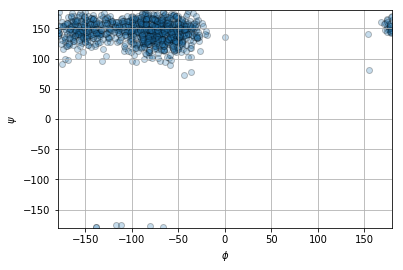

 
Running repeat run 1 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  0.787905216217041
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 5  6  8 18]
corr:
0.8750755620022523
Second naximal cv:
index:
[ 5  6  8 16]
corr:
0.8736696441246262
Number of cvs:
210
Maximal cv:
index:
[ 5  6  8 15]
corr:
0.33802770119199244
Second naximal cv:
index:
[ 5  6  8 14]
corr:
0.33320254010213923


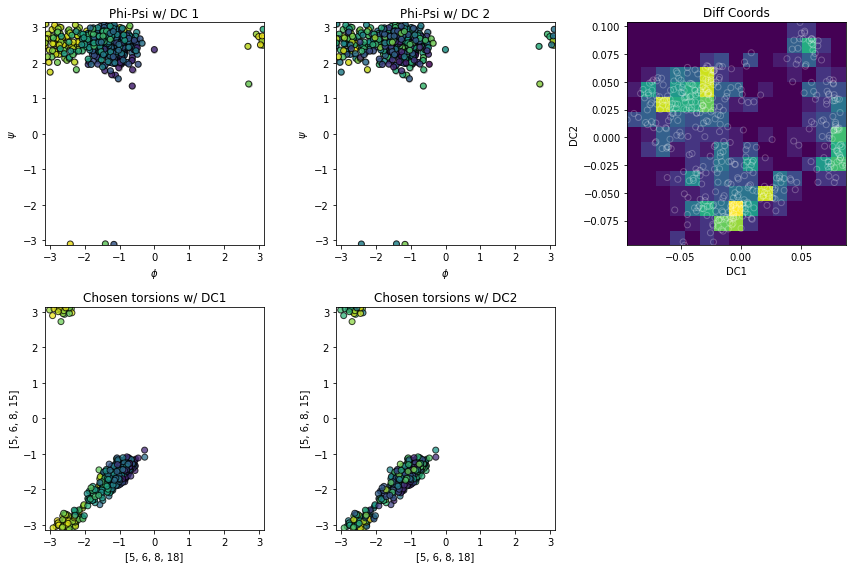

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 2 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 900 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.6730494499206543
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 4  8 10 16]
corr:
0.9535965196993416
Second naximal cv:
index:
[ 1  8 10 16]
corr:
0.9454150287056554
Number of cvs:
210
Maximal cv:
index:
[ 5  6 10 14]
corr:
0.8143141735564773
Second naximal cv:
index:
[ 5  6  8 10]
corr:
0.811027443536393


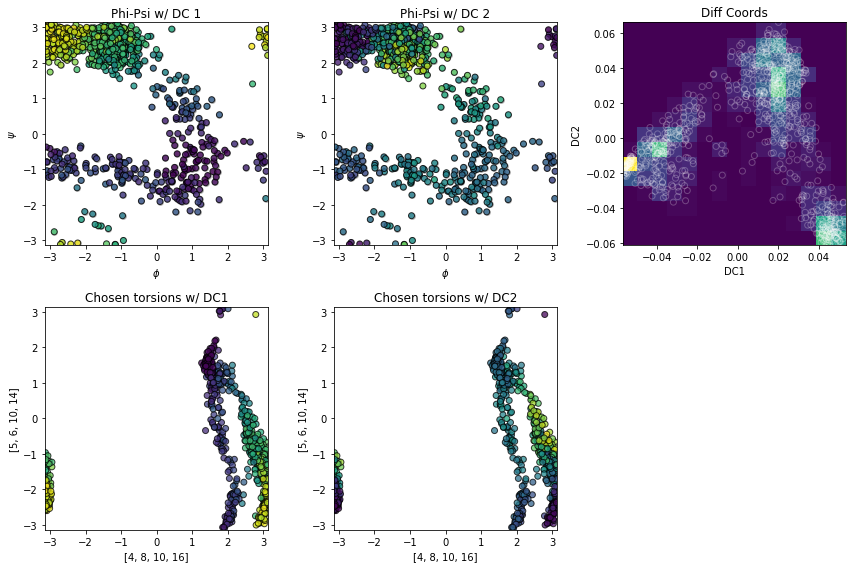

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 3 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 1350 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9325480461120605
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 4  8 10 18]
corr:
0.9470998832162552
Second naximal cv:
index:
[ 4  8 10 16]
corr:
0.9459730578824097
Number of cvs:
210
Maximal cv:
index:
[ 5  6 10 14]
corr:
0.8943391290165447
Second naximal cv:
index:
[ 5  6  8 14]
corr:
0.8898333184305088


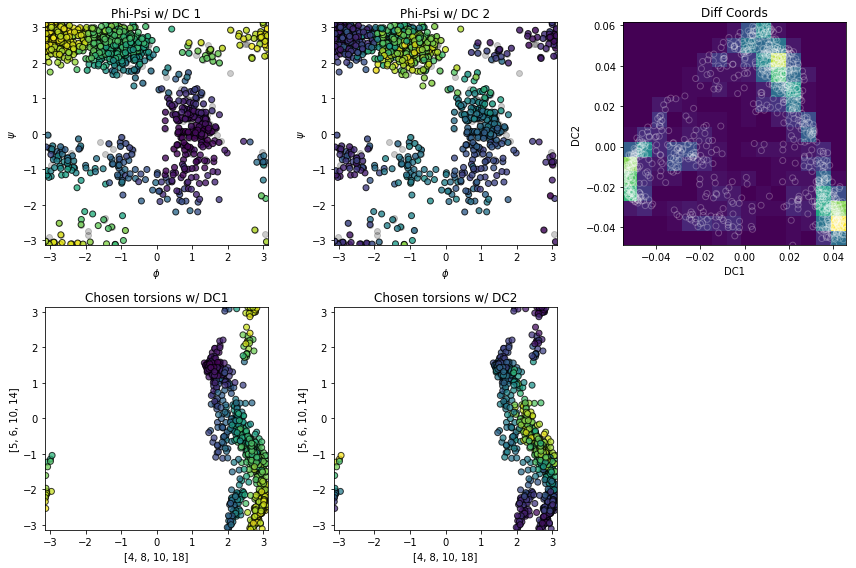

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 4 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 1800 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9315197467803955
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 6 10 15 18]
corr:
0.978343534847729
Second naximal cv:
index:
[ 1 10 15 18]
corr:
0.9776377377878921
Number of cvs:
210
Maximal cv:
index:
[ 5 10 15 18]
corr:
0.8985654481473007
Second naximal cv:
index:
[ 5 14 15 16]
corr:
0.8895416970953957


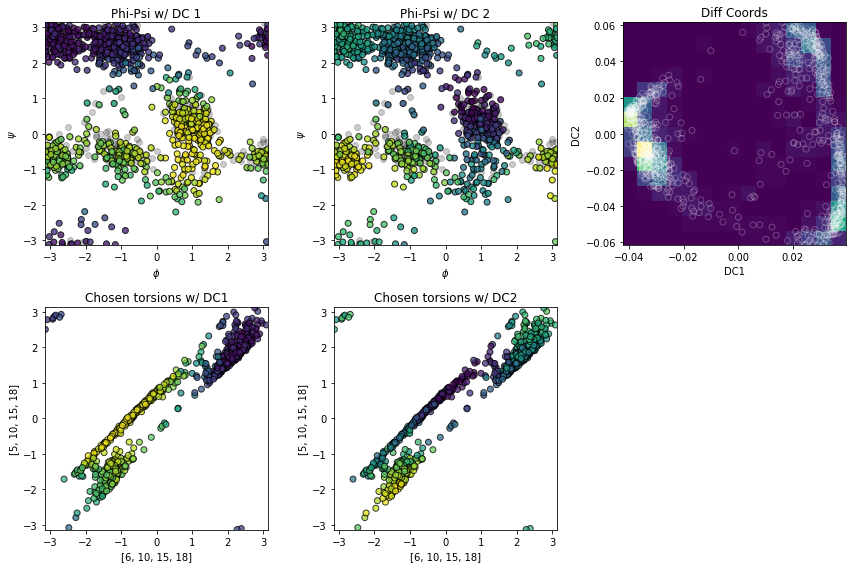

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 5 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 2250 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9344651699066162
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 6 10 15 18]
corr:
0.9708029645088765
Second naximal cv:
index:
[ 1 10 15 18]
corr:
0.9702577073833236
Number of cvs:
210
Maximal cv:
index:
[ 4  8 15 16]
corr:
0.8988856598370555
Second naximal cv:
index:
[ 4  8 15 18]
corr:
0.8981916403232352


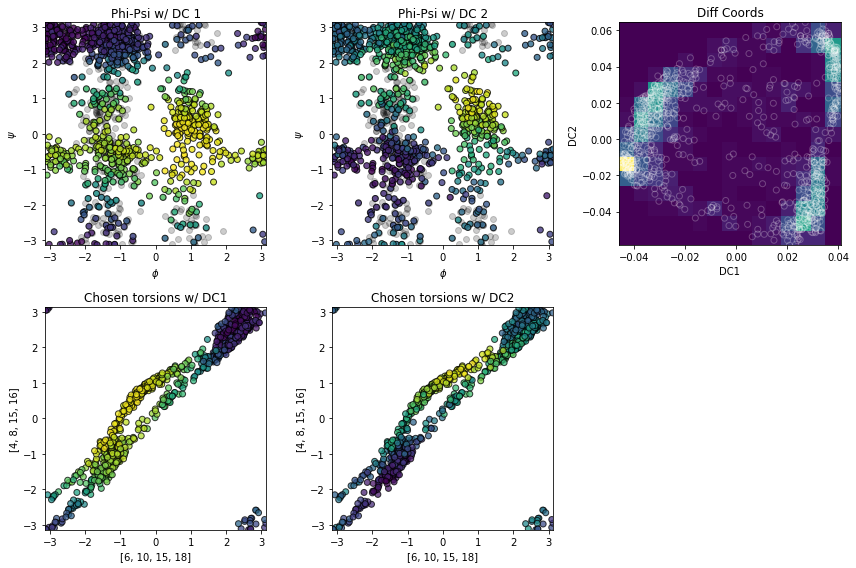

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 6 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 2700 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9489338397979736
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 6 10 15 16]
corr:
0.9811762642707939
Second naximal cv:
index:
[ 1 10 15 16]
corr:
0.9811690567941614
Number of cvs:
210
Maximal cv:
index:
[ 4  8 15 18]
corr:
0.9008734976211802
Second naximal cv:
index:
[ 4  8 15 16]
corr:
0.9007930275807411


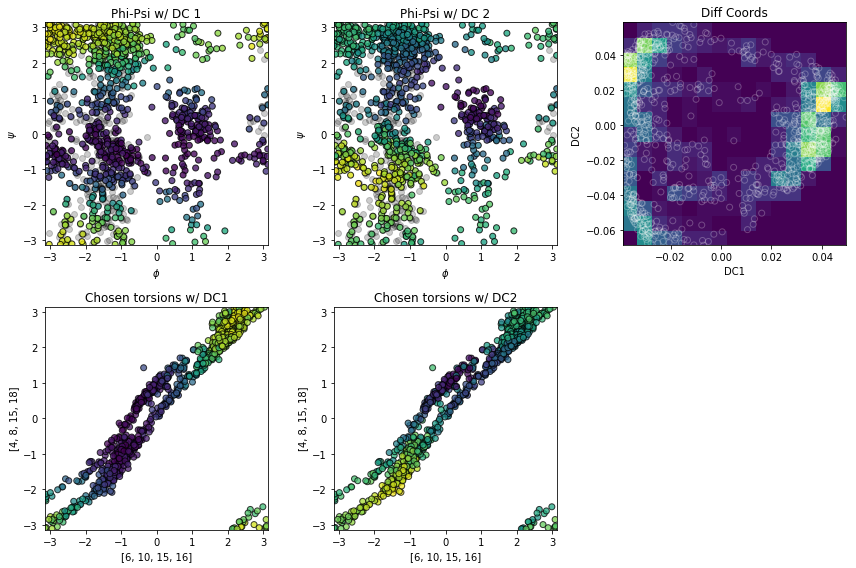

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 7 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 3150 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9621152877807617
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 1 10 15 16]
corr:
0.9820034745151531
Second naximal cv:
index:
[ 1  8 14 16]
corr:
0.9808143700258541
Number of cvs:
210
Maximal cv:
index:
[ 4  8 15 18]
corr:
0.9182806648706726
Second naximal cv:
index:
[ 4  8 15 16]
corr:
0.916054561197793


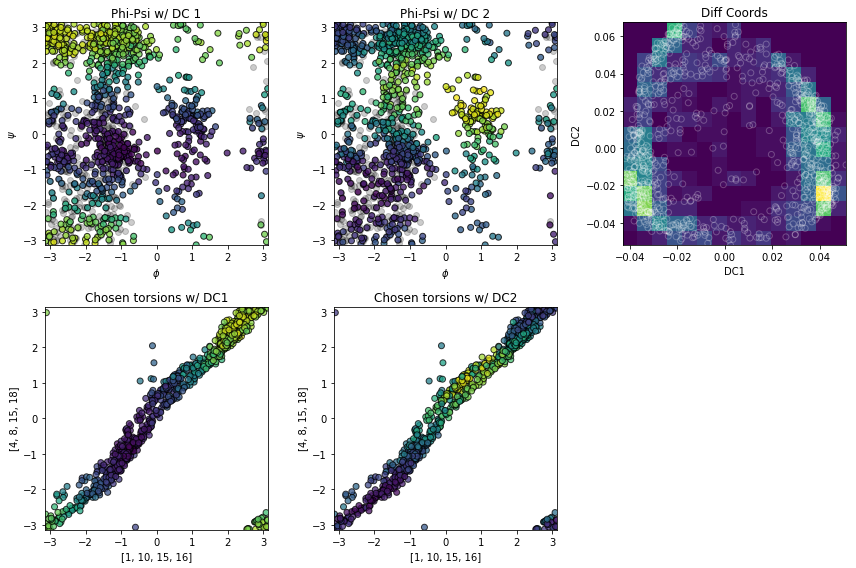

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 8 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 3600 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.938044786453247
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 1 10 15 18]
corr:
0.9867944211389239
Second naximal cv:
index:
[ 6  8 14 16]
corr:
0.9858062036700946
Number of cvs:
210
Maximal cv:
index:
[ 1  6 15 18]
corr:
0.9178137699660867
Second naximal cv:
index:
[ 4  8 15 18]
corr:
0.9147508869775468


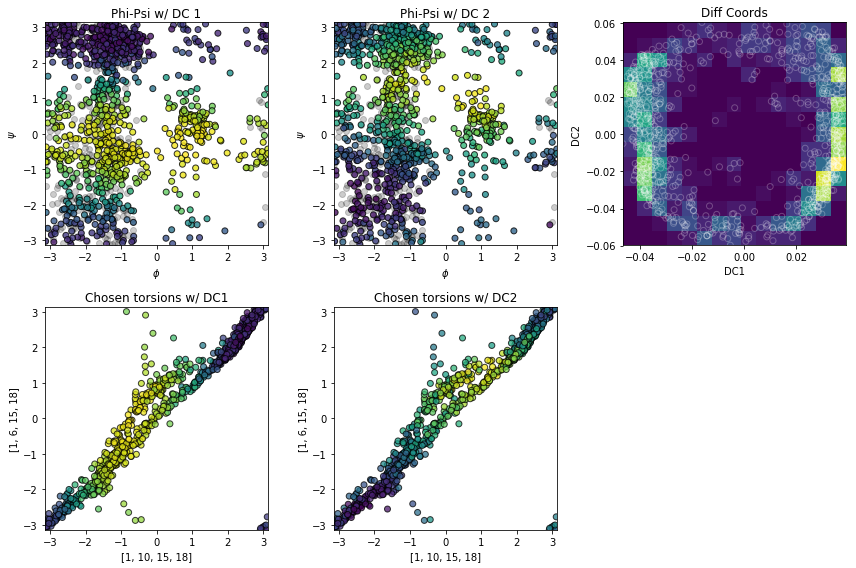

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 9 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 4050 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9421427249908447
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 1 10 15 16]
corr:
0.9816639789094745
Second naximal cv:
index:
[ 6 10 15 16]
corr:
0.9814668713087804
Number of cvs:
210
Maximal cv:
index:
[ 5  8 15 18]
corr:
0.8867146558593033
Second naximal cv:
index:
[ 5 10 15 18]
corr:
0.8857131549740666


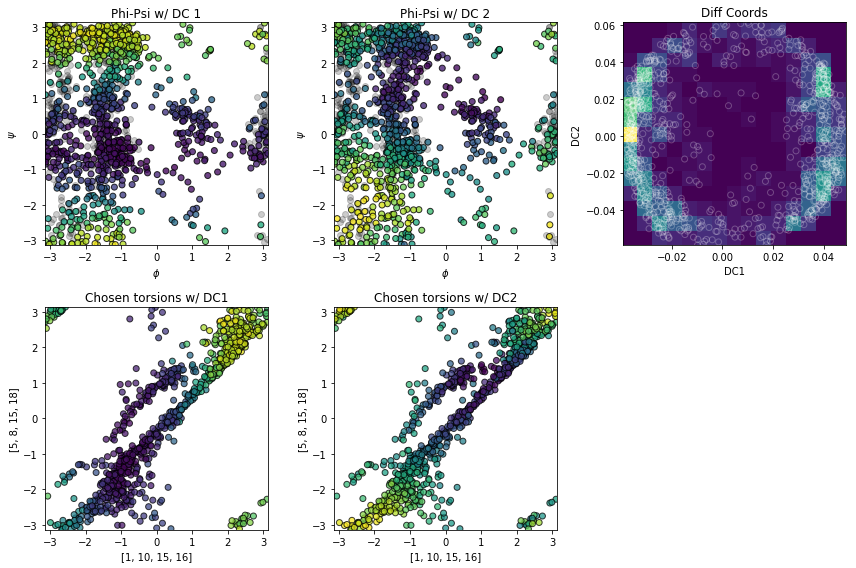

 -- Metadynamics
Running sim
Metadynamics Complete.
 
Running repeat run 10 of 10
 
 -- MDFeature
loaded traj:  <mdtraj.Trajectory with 450 frames, 2269 atoms, 752 residues, and unitcells>
all traj:  <mdtraj.Trajectory with 4500 frames, 2269 atoms, 752 residues, and unitcells>
Time taken for DMap:  1.9343862533569336
Dimension 1
Dimension 2
Number of cvs:
210
Maximal cv:
index:
[ 1 10 15 16]
corr:
0.981264404771745
Second naximal cv:
index:
[ 4 10 15 18]
corr:
0.9791685339885731
Number of cvs:
210
Maximal cv:
index:
[ 5 10 15 18]
corr:
0.9390975360309511
Second naximal cv:
index:
[ 5 10 15 16]
corr:
0.9324840444980644


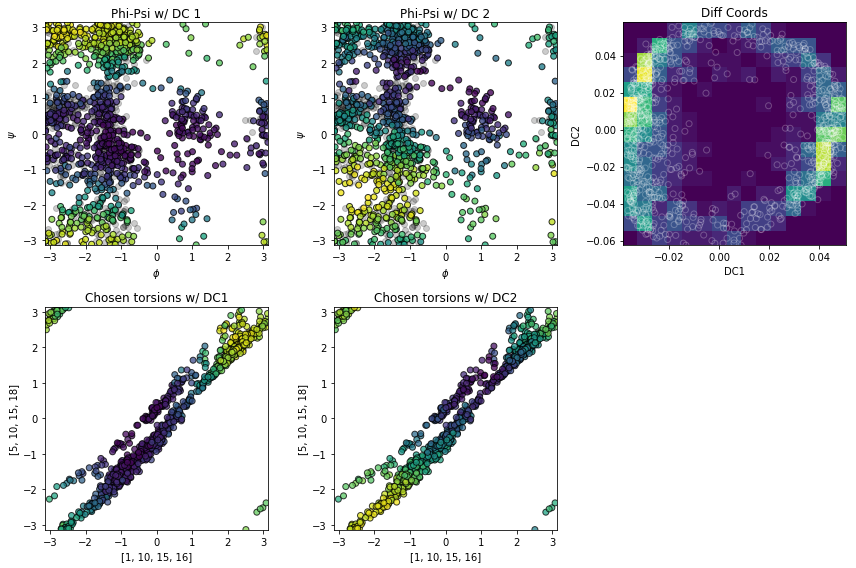

 -- Metadynamics
Running sim
Metadynamics Complete.
Completed all.


In [4]:
res = RunADP(  Repeats=10 ,   
             NSteps=50000, 
             nrpoints=1000, 
             PickRandomTorsions=False,
            Bias_Width=0.5,
            Bias_Str=1.0,
            nrneigh=256)